### Modeling Interest Rate Meta-feature
Use previous application data to predict 'CNT_PAYMENT', which is the term of previous credit of a previous application at Home Credit. 

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
t2 = pd.read_csv('test2.csv')
t1 = pd.read_csv('test1.csv')
tr = pd.read_csv('train.csv')
tr1=pd.read_csv('validation.csv')

In [3]:
tr.shape

(1297984, 111)

Use 90000 training cases - tested with full set and produced same results as about 90k.

In [4]:
tr=tr[:90000]
cnt=tr['CNT_PAYMENT']
tr=tr.drop(columns='CNT_PAYMENT')
tr['CNT_PAYMENT']=cnt

In [5]:
tr=tr.fillna(-1)
#tr1=tr1.fillna(-1)
clf = LGBMClassifier(
            nthread=4,
            objective='multiclass',
            n_estimators=1000,
            learning_rate=0.02, #originally 0.02
            num_leaves=50,
            max_depth=11,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=100)
print('fitting')

fitting


In [6]:
feats=tr.columns
feats=feats[2:110]
print(feats)

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'diff/goods', 'diff/credit',
       'credit_to_annuity', 'price_to_annuity', 'simple_diff', 'credit_term',
       ...
       'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'NAME_TYPE_SUITE_Children',
       'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
       'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B',
       'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied'],
      dtype='object', length=108)


Fitting model

In [7]:
model=clf.fit(tr[feats], tr['CNT_PAYMENT'], verbose= 500)

In [8]:
tr.head()

,Unnamed: 0,SK_ID_CURR,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,diff/goods,diff/credit,credit_to_annuity,price_to_annuity,...,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,CNT_PAYMENT
0,0,271877,1730.430,17145.0,17145.0,15,0.00000,0.000000,9.907942,9.907942,...,0,0,0,0,0,0,0,0,0,12
1,1,108129,25188.615,679671.0,607500.0,11,0.11880,0.106185,26.983262,24.118039,...,0,0,0,0,0,0,0,0,1,36
2,2,122040,15060.735,136444.5,112500.0,11,0.21284,0.175489,9.059618,7.469755,...,1,0,0,0,0,0,0,1,0,12
3,3,176158,47041.335,470790.0,450000.0,7,0.04620,0.044160,10.008007,9.566055,...,0,0,0,0,0,0,0,0,0,12
4,4,202054,31924.395,404055.0,337500.0,9,0.19720,0.164718,12.656622,10.571853,...,0,0,0,0,0,0,0,0,0,24


In [9]:
for frame in [[t2, 'test'],[t1,'training']]:
    test_df=frame[0]
    tag=frame[1]
    j=clf.predict_proba(test_df[feats], verbose= 500)
    test_df=test_df.fillna(-1)
    gc.collect()
    feature_importance_df = pd.DataFrame()
    sqsum=[]
    test_df['certainty']=0
    print(np.arange(0,j.shape[1]-1))
    print(j.shape)
    for k in np.arange(0,j.shape[1]-1):
            test_df['CNT_prob_'+str(k)]=j[:,k]
            test_df['CNT_prob_sq_'+str(k)]=test_df['CNT_prob_'+str(k)]*test_df['CNT_prob_'+str(k)]
            test_df['certainty']+=test_df['CNT_prob_sq_'+str(k)]

    predictions=pd.DataFrame()
    for k in np.arange(0,j.shape[1]-1):
            predictions[str(clf.classes_[k])]=j[:,k]
    predictions['best_guess']=predictions.idxmax(axis=1)
    predictions['best_guess']=predictions.best_guess.astype('float')
    test_df['lgbm_CNT']=predictions['best_guess']
    test_df[['SK_ID_CURR','lgbm_CNT','certainty']].to_csv('lgbm_CNT_'+tag+'.csv', index= False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(48744, 34)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
(307511, 34)


Only including results with more than 70% prediction accuracy

In [10]:
tpayments=pd.read_csv('lgbm_CNT_test.csv')
tpayments=tpayments[tpayments.certainty>0.7]
tpayments.to_csv(r'lgbm_CNT_test.csv')
payments=pd.read_csv('lgbm_CNT_training.csv')
payments=payments[payments.certainty>0.7]
payments.to_csv(r'lgbm_CNT_training.csv')

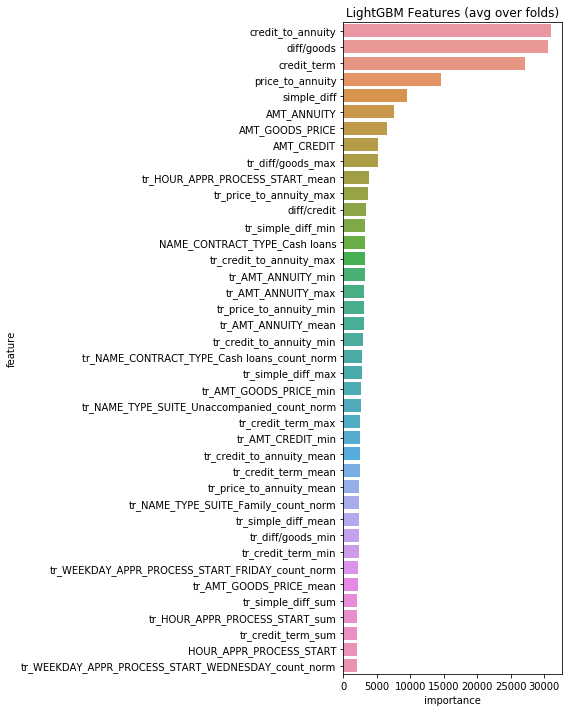

In [11]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = feats
feature_importance_df["importance"] = clf.feature_importances_
feature_importance_df[['feature', 'importance']].to_csv('importances.csv', index= False)

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
display_importances(feature_importance_df)